# Defining Our Strategy To Train A Machine Learning Model

In our preprocessing steps we had successfully handled missing values, outliers, encoded categorical feartures. In this notebook we will be loading the preprocessed .csv file and start to work on it.

We will need to scale the data first so that all of our data are in the same scale and easily comparable. 

We will also be needing to handle the class imbalances in our dataset. We will use upsampling technique like SMOTE to handle the imbalances and make sure our ML model can learn the patterns from all the classes and not just the majority class.

Next we will train our models; first we will be training with basic classification models and then move on to more advanced boosting techniques like XGBoost and CatBoost etc. We will run a loop to train all the models and train and tune hyperparameters in this loop and select the best model. We will save this tuned model to make predictions in our previously unseen test dataset which we set aside in the very beginning on the project.

We will evalute our trained model by classification reports and confusion metrics and find out in which classes the model is performing poorly.

Finally after we have selected our best model we will find out the feature importances and find out the top 3 factors that are affecting the employee performances

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy.stats import zscore
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_columns',None)
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
csv_file_path = '../../Data/Processed/data_processed.csv'
encoded_df = pd.read_csv(csv_file_path)
encoded_df.head()

,Age,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_Male,EducationBackground_Life Sciences,EducationBackground_Marketing,EducationBackground_Medical,EducationBackground_Other,EducationBackground_Technical Degree,MaritalStatus_Married,MaritalStatus_Single,EmpDepartment_Development,EmpDepartment_Finance,EmpDepartment_Human Resources,EmpDepartment_Research & Development,EmpDepartment_Sales,EmpJobRole_Data Scientist,EmpJobRole_Delivery Manager,EmpJobRole_Developer,EmpJobRole_Finance Manager,EmpJobRole_Healthcare Representative,EmpJobRole_Human Resources,EmpJobRole_Laboratory Technician,EmpJobRole_Manager,EmpJobRole_Manager R&D,EmpJobRole_Manufacturing Director,EmpJobRole_Research Director,EmpJobRole_Research Scientist,EmpJobRole_Sales Executive,EmpJobRole_Sales Representative,EmpJobRole_Senior Developer,EmpJobRole_Senior Manager R&D,EmpJobRole_Technical Architect,EmpJobRole_Technical Lead,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely,OverTime_Yes,Attrition_Yes,PerformanceRating
0,58,23,4,1,88,3,1,3,1.0,12,4,2.0,3.0,3,2.0,2.0,2.0,2.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,31,8,2,4,96,4,1,2,8.5,18,4,8.0,3.0,3,3.0,2.0,0.0,2.0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,36,1,2,2,56,3,2,4,1.0,14,4,18.0,1.0,2,18.0,14.0,4.0,11.0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1
3,19,22,1,4,50,3,1,3,1.0,19,4,0.0,2.0,2,0.0,0.0,0.0,0.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1
4,30,8,2,3,62,3,3,3,5.0,11,1,10.0,2.0,4,8.0,4.0,7.0,7.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


# Scaling the features

We will make a function to scale the data, so that we can save the function and call the function when we have to do the exact same scaling for test dataset in prediction notebook.

In [3]:
def scale_data(df, scaler=None):
    from sklearn.preprocessing import MinMaxScaler

    X = df.drop(columns=['PerformanceRating'])
    y = df['PerformanceRating']

    numerical_cols = X.select_dtypes(include=['int64', 'float64'])

    if scaler is None:
        scaler = MinMaxScaler()
        scaled_numerical_cols = scaler.fit_transform(numerical_cols)
    else:
        scaled_numerical_cols = scaler.transform(numerical_cols)

    scaled_df = pd.DataFrame(scaled_numerical_cols, columns=numerical_cols.columns)

    encoded_categorical_cols = X.select_dtypes(include=['uint8']).reset_index(drop=True)

    final_X = pd.concat([scaled_df, encoded_categorical_cols], axis=1)

    return final_X


final_X = scale_data(encoded_df)


In [4]:
final_X

,Age,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_Male,EducationBackground_Life Sciences,EducationBackground_Marketing,EducationBackground_Medical,EducationBackground_Other,EducationBackground_Technical Degree,MaritalStatus_Married,MaritalStatus_Single,EmpDepartment_Development,EmpDepartment_Finance,EmpDepartment_Human Resources,EmpDepartment_Research & Development,EmpDepartment_Sales,EmpJobRole_Data Scientist,EmpJobRole_Delivery Manager,EmpJobRole_Developer,EmpJobRole_Finance Manager,EmpJobRole_Healthcare Representative,EmpJobRole_Human Resources,EmpJobRole_Laboratory Technician,EmpJobRole_Manager,EmpJobRole_Manager R&D,EmpJobRole_Manufacturing Director,EmpJobRole_Research Director,EmpJobRole_Research Scientist,EmpJobRole_Sales Executive,EmpJobRole_Sales Representative,EmpJobRole_Senior Developer,EmpJobRole_Senior Manager R&D,EmpJobRole_Technical Architect,EmpJobRole_Technical Lead,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely,OverTime_Yes,Attrition_Yes
0,0.952381,0.785714,0.75,0.000000,0.828571,0.666667,0.00,0.666667,0.117647,0.071429,1.000000,0.070175,0.625,0.666667,0.097561,0.137931,0.266667,0.137931,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.309524,0.250000,0.25,1.000000,0.942857,1.000000,0.00,0.333333,1.000000,0.500000,1.000000,0.280702,0.625,0.666667,0.146341,0.137931,0.000000,0.137931,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.428571,0.000000,0.25,0.333333,0.371429,0.666667,0.25,1.000000,0.117647,0.214286,1.000000,0.631579,0.125,0.333333,0.878049,0.965517,0.533333,0.758621,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.023810,0.750000,0.00,1.000000,0.285714,0.666667,0.00,0.666667,0.117647,0.571429,1.000000,0.000000,0.375,0.333333,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.285714,0.250000,0.25,0.666667,0.457143,0.666667,0.50,0.666667,0.588235,0.000000,0.000000,0.350877,0.375,1.000000,0.390244,0.275862,0.933333,0.482759,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.261905,0.250000,0.75,0.333333,0.671429,0.000000,0.00,0.000000,0.117647,0.000000,1.000000,0.245614,0.875,0.333333,0.341463,0.482759,0.000000,0.482759,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
956,0.285714,0.392857,0.50,0.333333,0.757143,0.666667,0.25,0.666667,0.000000,0.000000,0.333333,0.210526,1.000,0.666667,0.243902,0.275862,0.533333,0.275862,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
957,0.380952,0.785714,0.50,0.333333,0.185714,0.666667,0.50,0.000000,1.000000,0.285714,0.666667,0.385965,0.375,0.666667,0.146341,0.137931,0.000000,0.137931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
958,0.380952,0.142857,0.50,0.666667,0.214286,0.333333,0.50,0.000000,0.235294,0.071429,1.000000,0.4912

In [5]:
y = encoded_df['PerformanceRating']

In [6]:
y.value_counts()

1    690
0    165
2    105
Name: PerformanceRating, dtype: int64

# Using SMOTE For Class Imbalances

In [7]:
smote = SMOTE(random_state=42)

# Split the data into training and testing sets without SMOTE
X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.2, random_state=42)


# Split the data into training and testing sets with SMOTE

X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(final_X, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

In [8]:
print(f"Before Smote: {Counter(y_train)}")
print(f"After Smote: {Counter(y_train_resampled)}")

Before Smote: Counter({1: 547, 0: 132, 2: 89})
After Smote: Counter({0: 547, 2: 547, 1: 547})


# Predicting with Basic Classification Models

In [9]:
classifiers = [
    {'name': 'Logistic Regression', 'classifier': LogisticRegression(), 'param_grid': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}},
    {'name': 'Random Forest', 'classifier': RandomForestClassifier(), 'param_grid': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    {'name': 'Decision Tree', 'classifier': DecisionTreeClassifier(), 'param_grid': {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
]

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'best_params'])

for classifier in classifiers:
    name = classifier['name']
    clf = classifier['classifier']
    param_grid = classifier['param_grid']
    
    random_search = RandomizedSearchCV(clf, param_grid, n_iter=10, scoring='accuracy', n_jobs=-1, cv=5)
    random_search.fit(X_train_resampled, y_train_resampled)

    best_clf = random_search.best_estimator_

    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    metrics_df = metrics_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1, 'best_params': random_search.best_params_}, ignore_index=True)


metrics_df['Mean'] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-score']].mean(axis=1)

metrics_df = metrics_df.sort_values(by='Mean', ascending=False)

metrics_df


,Model,Accuracy,Precision,Recall,F1-score,best_params,Mean
1,Random Forest,0.901042,0.904571,0.901042,0.902280,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.902234
2,Decision Tree,0.864583,0.880774,0.864583,0.869678,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.869905
0,Logistic Regression,0.739583,0.800651,0.739583,0.757462,"{'solver': 'saga', 'penalty': 'l2', 'C': 10}",0.759320


# Predicting with Boosted Classification Models

In [10]:
classifiers = [
    {'name': 'CatBoost', 
     'classifier': CatBoostClassifier(), 
     'param_grid': {'iterations': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1]}},
    {'name': 'LightGBM', 
     'classifier': LGBMClassifier(), 
     'param_grid': {'n_estimators': [50, 100, 200, 400], 'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'subsample': [0.5, 0.8, 1.0], 'colsample_bytree': [0.5, 0.8, 1.0], 'gamma': [0, 0.1, 0.2, 0.3, 0.4]}},
    {'name': 'XGBoost', 
     'classifier': XGBClassifier(), 
     'param_grid': {'n_estimators': [50, 100, 200, 400], 'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'subsample': [0.5, 0.8, 1.0], 'colsample_bytree': [0.5, 0.8, 1.0], 'gamma': [0, 0.1, 0.2, 0.3, 0.4]}}
]

# metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'best_params'])

for classifier in classifiers:
    name = classifier['name']
    clf = classifier['classifier']
    param_grid = classifier['param_grid']
    
    random_search = RandomizedSearchCV(clf, param_grid, n_iter=10, scoring='accuracy', n_jobs=-1, cv=5, verbose=0)
    random_search.fit(X_train_resampled, y_train_resampled)

    best_clf = random_search.best_estimator_

    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    metrics_df = pd.concat([
        pd.DataFrame({'Model': [name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-score': [f1], 'best_params': [random_search.best_params_]})
    ], ignore_index=True).append(metrics_df, ignore_index=True)

metrics_df['Mean'] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-score']].mean(axis=1)




0:	learn: 0.9811551	total: 157ms	remaining: 46.9s
1:	learn: 0.8856585	total: 166ms	remaining: 24.7s
2:	learn: 0.8038094	total: 173ms	remaining: 17.1s
3:	learn: 0.7368808	total: 180ms	remaining: 13.3s
4:	learn: 0.6808263	total: 187ms	remaining: 11.1s
5:	learn: 0.6296029	total: 194ms	remaining: 9.53s
6:	learn: 0.5921320	total: 202ms	remaining: 8.44s
7:	learn: 0.5559447	total: 209ms	remaining: 7.62s
8:	learn: 0.5227371	total: 216ms	remaining: 6.98s
9:	learn: 0.4959089	total: 223ms	remaining: 6.47s
10:	learn: 0.4696392	total: 232ms	remaining: 6.1s
11:	learn: 0.4432872	total: 241ms	remaining: 5.77s
12:	learn: 0.4231528	total: 248ms	remaining: 5.47s
13:	learn: 0.4049199	total: 255ms	remaining: 5.21s
14:	learn: 0.3881310	total: 262ms	remaining: 4.98s
15:	learn: 0.3715985	total: 270ms	remaining: 4.78s
16:	learn: 0.3547327	total: 277ms	remaining: 4.6s
17:	learn: 0.3425459	total: 284ms	remaining: 4.45s
18:	learn: 0.3292214	total: 291ms	remaining: 4.3s
19:	learn: 0.3159430	total: 298ms	remaining:

165:	learn: 0.0634086	total: 1.43s	remaining: 1.16s
166:	learn: 0.0630942	total: 1.44s	remaining: 1.15s
167:	learn: 0.0628131	total: 1.45s	remaining: 1.14s
168:	learn: 0.0626396	total: 1.45s	remaining: 1.13s
169:	learn: 0.0623212	total: 1.46s	remaining: 1.12s
170:	learn: 0.0621258	total: 1.47s	remaining: 1.11s
171:	learn: 0.0620039	total: 1.48s	remaining: 1.1s
172:	learn: 0.0616635	total: 1.48s	remaining: 1.09s
173:	learn: 0.0613915	total: 1.49s	remaining: 1.08s
174:	learn: 0.0610568	total: 1.5s	remaining: 1.07s
175:	learn: 0.0607715	total: 1.5s	remaining: 1.06s
176:	learn: 0.0606402	total: 1.51s	remaining: 1.05s
177:	learn: 0.0604294	total: 1.52s	remaining: 1.04s
178:	learn: 0.0603180	total: 1.52s	remaining: 1.03s
179:	learn: 0.0597235	total: 1.53s	remaining: 1.02s
180:	learn: 0.0592478	total: 1.54s	remaining: 1.01s
181:	learn: 0.0587149	total: 1.55s	remaining: 1s
182:	learn: 0.0585425	total: 1.55s	remaining: 994ms
183:	learn: 0.0584379	total: 1.56s	remaining: 985ms
184:	learn: 0.0580

In [11]:
metrics_df.sort_values('Mean',ascending=False)

,Model,Accuracy,Precision,Recall,F1-score,best_params,Mean
0,XGBoost,0.921875,0.923282,0.921875,0.922296,"{'subsample': 1.0, 'n_estimators': 100, 'min_c...",0.922332
1,LightGBM,0.911458,0.913086,0.911458,0.912145,"{'subsample': 0.5, 'n_estimators': 50, 'min_ch...",0.912037
2,CatBoost,0.906250,0.909281,0.906250,0.907434,"{'learning_rate': 0.1, 'iterations': 300}",0.907304
3,Random Forest,0.901042,0.904571,0.901042,0.902280,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.902234
4,Decision Tree,0.864583,0.880774,0.864583,0.869678,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.869905
5,Logistic Regression,0.739583,0.800651,0.739583,0.757462,"{'solver': 'saga', 'penalty': 'l2', 'C': 10}",0.759320


In [12]:
metrics_df_best = metrics_df.sort_values('Mean',ascending=False)

In [13]:
metrics_df_best

,Model,Accuracy,Precision,Recall,F1-score,best_params,Mean
0,XGBoost,0.921875,0.923282,0.921875,0.922296,"{'subsample': 1.0, 'n_estimators': 100, 'min_c...",0.922332
1,LightGBM,0.911458,0.913086,0.911458,0.912145,"{'subsample': 0.5, 'n_estimators': 50, 'min_ch...",0.912037
2,CatBoost,0.906250,0.909281,0.906250,0.907434,"{'learning_rate': 0.1, 'iterations': 300}",0.907304
3,Random Forest,0.901042,0.904571,0.901042,0.902280,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.902234
4,Decision Tree,0.864583,0.880774,0.864583,0.869678,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.869905
5,Logistic Regression,0.739583,0.800651,0.739583,0.757462,"{'solver': 'saga', 'penalty': 'l2', 'C': 10}",0.759320


In [14]:
classifiers = [
    {'name': 'CatBoost', 
     'classifier': CatBoostClassifier(), 
     'param_grid': {'iterations': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1]}},
    {'name': 'LightGBM', 
     'classifier': LGBMClassifier(), 
     'param_grid': {'n_estimators': [50, 100, 200, 400], 'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'subsample': [0.5, 0.8, 1.0], 'colsample_bytree': [0.5, 0.8, 1.0], 'gamma': [0, 0.1, 0.2, 0.3, 0.4]}},
    {'name': 'XGBoost', 
     'classifier': XGBClassifier(), 
     'param_grid': {'n_estimators': [50, 100, 200, 400], 'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'subsample': [0.5, 0.8, 1.0], 'colsample_bytree': [0.5, 0.8, 1.0], 'gamma': [0, 0.1, 0.2, 0.3, 0.4]}},
    {'name': 'Logistic Regression', 'classifier': LogisticRegression(), 
     'param_grid': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}},
    {'name': 'Random Forest', 'classifier': RandomForestClassifier(), 
     'param_grid': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    {'name': 'Decision Tree', 'classifier': DecisionTreeClassifier(), 
     'param_grid': {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
]

In [15]:
for i in classifiers:
    if i['name'] == metrics_df_best.head(1)['Model'].values[0]:
        clf= metrics_df_best.head(1)['Model'].values[0]
        param_grid = metrics_df_best.head(1)['best_params'].values[0]
        

In [16]:
clf

'XGBoost'

In [17]:
param_grid

{'subsample': 1.0,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 20,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.8}

In [18]:
if clf == 'LightGBM':
    best_clf = LGBMClassifier(colsample_bytree = param_grid['colsample_bytree'],
                        gamma=param_grid['gamma'],
                        learning_rate = param_grid['learning_rate'],
                        max_depth = param_grid['max_depth'],
                        min_child_weight =param_grid['min_child_weight'],
                        n_estimators = param_grid['n_estimators'],
                        subsample = param_grid['subsample']                         
                        )
if clf == 'CatBoost':
    best_clf = CatBoostClassifier(iterations = param_grid['iterations'],
                        learning_rate=param_grid['learning_rate']                        
                        )
    
if clf == 'XGBoost':
    best_clf = XGBClassifier(colsample_bytree = param_grid['colsample_bytree'],
                        gamma=param_grid['gamma'],
                        learning_rate = param_grid['learning_rate'],
                        max_depth = param_grid['max_depth'],
                        min_child_weight =param_grid['min_child_weight'],
                        n_estimators = param_grid['n_estimators'],
                        subsample = param_grid['subsample']                         
                        )

if clf == 'Decision Tree':
    best_clf = DecisionTreeClassifier(max_depth = param_grid['max_depth'],
                        min_samples_split=param_grid['min_samples_split'],
                        min_samples_leaf=param_grid['min_samples_leaf']
                        )
    
if clf == 'Random Forest':
    best_clf = RandomForestClassifier(max_depth = param_grid['max_depth'],
                        min_samples_split=param_grid['min_samples_split'],
                        min_samples_leaf=param_grid['min_samples_leaf'],
                        n_estimators=param_grid['n_estimators']              
                        )
    

# Best Model 

In [19]:
best_clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# Save Best Model

In [20]:
import joblib

# Save the best_clf model to a .pkl file
model_filename = 'best_model.pkl'
joblib.dump(best_clf, model_filename)

['best_model.pkl']

# Evaluating Our Trained Model

In [21]:
from sklearn.metrics import classification_report
class_names = ['Class 2', 'Class 3', 'Class 4']
classification_rep = classification_report(y_test, y_pred, target_names=class_names)

print(classification_rep)

              precision    recall  f1-score   support

     Class 2       0.88      0.85      0.86        33
     Class 3       0.95      0.94      0.95       143
     Class 4       0.78      0.88      0.82        16

    accuracy                           0.92       192
   macro avg       0.87      0.89      0.88       192
weighted avg       0.92      0.92      0.92       192



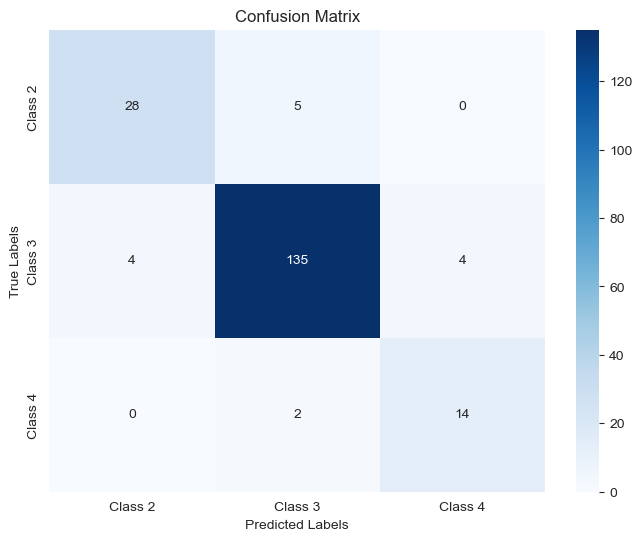

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Model Performance Report

**Class 2 (Employee Performance Rating 2):**
This class shows good precision and recall, indicating that the model is effective at identifying employees with a performance rating of 2. However, there is a slight trade-off between precision and recall.

**Class 3 (Employee Performance Rating 3):**
The model demonstrates strong precision and recall for employees with a performance rating of 3, suggesting accurate identification of this category.


**Class 4 (Employee Performance Rating 4):**
While the recall is relatively high for employees with a performance rating of 4, the precision is lower. This indicates that the model is capturing a significant portion of these instances, but there may be some false positives.
Overall, the model appears to perform well for classes 2 and 3, with balanced precision and recall. For class 4, there is a trade-off between precision and recall, suggesting room for further improvement, possibly by adjusting the model's decision threshold or exploring other techniques to address the class imbalance.

# Top 3 Important Factors Effecting Employee Performance

In [23]:
best_clf.fit(X_train_resampled, y_train_resampled)
feature_importance = best_clf.feature_importances_
importance_df = pd.DataFrame({'Feature': final_X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_n = 3
top_features = importance_df.head(top_n)['Feature']
print("Top", top_n, "Important Features:")
print(top_features)

Top 3 Important Features:
3     EmpEnvironmentSatisfaction
9       EmpLastSalaryHikePercent
16       YearsSinceLastPromotion
Name: Feature, dtype: object
